# Part 3 Feature Selection 


### Goal: 
Use 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 100% of randomly selecteed features to train the neural network and test on it respectively. You build 9 systems. Plot a graph where the x-axis indicates the percentage of features you used to train a system, and the y-axis indicate the accuracy on the test set of each system 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import h5py
import numpy as np
import matplotlib.pyplot as plt 

import sklearn 
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras import models 
from keras.layers import Dense
from keras import optimizers 
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import math

import tensorflow as tf

Using TensorFlow backend.


In [2]:
def dataCollection(): 
    print("Data Collection")
    wine = sklearn.datasets.load_wine()
    
    df = pd.DataFrame(wine.data)
    df.columns = wine.feature_names
    df["class"] = wine.target
    
    labels = df.loc[:,["class"]] 
    features = df.drop(["class"],axis=1)
    
    return features, labels

Discussion:     
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While there are various types of feature selection and dimensionalty reduction, I chose to use a type of feature selection called recursive feature elimination (RFE) which works by recursively removing attributes and building a model on those attributes that remain. I chose to use a random forest classifier to identify attributes contribute the most to predicting the labels.      
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The number of features to select by the RFE is determined by multiplying the percentage to the total number of features in the dataset(13)

In [3]:
def rfe(percentage, features, labels): 
    '''
    Applies recursive feature elimination to find percentage of features to use 
    Returns selected features 
    '''
    print("RFE")
    rfc = RandomForestClassifier(random_state = 101)
    
    # Number of features to select is the percentage given * total features - rounded 
    rfe = RFE(rfc, n_features_to_select = math.floor(percentage*13))
    fit = rfe.fit(features, labels)
    
    print("Number of Features", fit.n_features_)
    print("Ranking of Features", fit.ranking_)
    print("Selected Features", fit.support_)
    
    # selected features from original dataset  
    features = features.loc[:, list(fit.support_)] 
    
    return features 

In [4]:
def dataPrep(features, labels):
    '''
    Prepares features and labels into its respective sets 
    '''
    print("dataPrep")
    xtrain, xtest, ytrain, ytest = train_test_split(features, labels)
    
    #convert labels to categorical 
    ytrain = to_categorical(ytrain, 3)
    ytest = to_categorical(ytest,3)
    
    # Scale data 
    scale = MinMaxScaler(feature_range=(0,1))
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.fit_transform(xtest)
    return xtrain, xtest, ytrain, ytest 

In [5]:
def trainModel(xtrain, ytrain):
    '''
    Builds and runs training model 
    '''
    print("Training the Model")
    
    model = Sequential()
    model.add(Dense(10, input_dim=xtrain.shape[1],activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    # Save weights 
    checkpoint = ModelCheckpoint("model_part3.hdf5", monitor="loss", verbose=1, save_best_only = True, mode="auto", period=1)
    
    # Apply early stopping to prevent overfitting 
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',restore_best_weights=True)
    
    # Run Model 
    history = model.fit(xtrain, ytrain, batch_size=50, epochs=2000, verbose =0, validation_split=0.3, callbacks=[checkpoint,monitor])
    

In [6]:
def testModel(xtest, ytest): 
    '''
    Builds and runs testing model 
    '''
    print("Testing the model")
    
    evalModel = Sequential()
    evalModel.add(Dense(10, input_dim=xtest.shape[1],activation='relu'))
    evalModel.add(Dense(8, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(6, activation='relu'))
    evalModel.add(Dense(4, activation='relu'))
    evalModel.add(Dense(3, activation='softmax'))


    evalModel.load_weights('model_part3.hdf5')
    evalModel.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-3), metrics = ["acc"])
    
    lossAndAcc = evalModel.evaluate(xtest, ytest)

    return lossAndAcc[1]

In [7]:
def main(percent_features, accuracy): 
    '''
    Driver for program 
    '''
    features, labels = dataCollection()
   
    for i in range(len(percent_features)): 
        print("====================================================")
        print("Percent Features ", percent_features[i])
 
        # Call Recursive Feature Elimation given percent features 
        new_features = rfe(percent_features[i], features, labels)
        
        # Split features and labels 
        xtrain, xtest, ytrain, ytest = dataPrep(new_features, labels)
        
        # Train Model 
        trainModel(xtrain, ytrain)
        
        # Test Model
        curr_acc = testModel(xtest, ytest)
        
        # Add accuracy to our list 
        accuracy.append(curr_acc)
        
        print("====================================================\n")

    
    return accuracy


In [8]:
percent_features = [0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accuracy = []

acc = main(percent_features, accuracy)

Data Collection
Percent Features  0.2
RFE
2
Number of Features 2
Ranking of Features [ 4  8 11  9  7  6  1 12 10  1  5  3  2]
Selected Features [False False False False False False  True False False  True False False
 False]
dataPrep
Training the Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Epoch 00001: loss improved from inf to 1.08517, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.08517 to 1.08152, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.08152 to 1.07867, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.07867 to 1.07644, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.07644 to 1.07426, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.07426 to 1.07205, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.07205 to 1.06989, saving model to model_part3.hdf5

Epoch 00008: loss improved f


Epoch 00090: loss improved from 0.82118 to 0.81885, saving model to model_part3.hdf5

Epoch 00091: loss improved from 0.81885 to 0.81707, saving model to model_part3.hdf5

Epoch 00092: loss improved from 0.81707 to 0.81465, saving model to model_part3.hdf5

Epoch 00093: loss improved from 0.81465 to 0.81280, saving model to model_part3.hdf5

Epoch 00094: loss improved from 0.81280 to 0.81049, saving model to model_part3.hdf5

Epoch 00095: loss improved from 0.81049 to 0.80843, saving model to model_part3.hdf5

Epoch 00096: loss improved from 0.80843 to 0.80772, saving model to model_part3.hdf5

Epoch 00097: loss improved from 0.80772 to 0.80500, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.80500 to 0.80306, saving model to model_part3.hdf5

Epoch 00099: loss did not improve from 0.80306

Epoch 00100: loss improved from 0.80306 to 0.79963, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.79963 to 0.79814, saving model to model_part3.hdf5

Epoch

Number of Features 3
Ranking of Features [ 3  7 10  8  6  5  1 11  9  1  4  2  1]
Selected Features [False False False False False False  True False False  True False False
  True]
dataPrep
Training the Model

Epoch 00001: loss improved from inf to 1.09771, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.09771 to 1.09315, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.09315 to 1.09063, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.09063 to 1.08793, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.08793 to 1.08529, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.08529 to 1.08244, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.08244 to 1.07957, saving model to model_part3.hdf5

Epoch 00008: loss improved from 1.07957 to 1.07712, saving model to model_part3.hdf5

Epoch 00009: loss improved from 1.07712 to 1.07434, saving model to model_part3.hdf5

Epoch 00010: loss im


Epoch 00097: loss improved from 0.79430 to 0.79176, saving model to model_part3.hdf5

Epoch 00098: loss improved from 0.79176 to 0.78890, saving model to model_part3.hdf5

Epoch 00099: loss improved from 0.78890 to 0.78630, saving model to model_part3.hdf5

Epoch 00100: loss improved from 0.78630 to 0.78368, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.78368 to 0.78107, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.78107 to 0.77849, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.77849 to 0.77565, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.77565 to 0.77467, saving model to model_part3.hdf5

Epoch 00105: loss improved from 0.77467 to 0.77187, saving model to model_part3.hdf5

Epoch 00106: loss improved from 0.77187 to 0.76928, saving model to model_part3.hdf5

Epoch 00107: loss did not improve from 0.76928

Epoch 00108: loss improved from 0.76928 to 0.76359, saving model to model_part3.hdf5

Epoch


Epoch 00204: loss did not improve from 0.59479

Epoch 00205: loss improved from 0.59479 to 0.59176, saving model to model_part3.hdf5

Epoch 00206: loss improved from 0.59176 to 0.58946, saving model to model_part3.hdf5

Epoch 00207: loss improved from 0.58946 to 0.58798, saving model to model_part3.hdf5

Epoch 00208: loss improved from 0.58798 to 0.58605, saving model to model_part3.hdf5

Epoch 00209: loss did not improve from 0.58605

Epoch 00210: loss improved from 0.58605 to 0.58349, saving model to model_part3.hdf5

Epoch 00211: loss improved from 0.58349 to 0.58082, saving model to model_part3.hdf5

Epoch 00212: loss did not improve from 0.58082

Epoch 00213: loss improved from 0.58082 to 0.57765, saving model to model_part3.hdf5

Epoch 00214: loss improved from 0.57765 to 0.57737, saving model to model_part3.hdf5
Testing the model
45/45 [==============================] - 0s 871us/step

Percent Features  0.4
RFE
5
Number of Features 5
Ranking of Features [1 5 8 6 4 3 1 9 7 1 2 1 


Epoch 00084: loss improved from 0.43795 to 0.43704, saving model to model_part3.hdf5

Epoch 00085: loss improved from 0.43704 to 0.42654, saving model to model_part3.hdf5

Epoch 00086: loss did not improve from 0.42654

Epoch 00087: loss improved from 0.42654 to 0.41676, saving model to model_part3.hdf5

Epoch 00088: loss improved from 0.41676 to 0.40973, saving model to model_part3.hdf5

Epoch 00089: loss improved from 0.40973 to 0.40519, saving model to model_part3.hdf5

Epoch 00090: loss did not improve from 0.40519

Epoch 00091: loss improved from 0.40519 to 0.39477, saving model to model_part3.hdf5

Epoch 00092: loss improved from 0.39477 to 0.38906, saving model to model_part3.hdf5

Epoch 00093: loss improved from 0.38906 to 0.38398, saving model to model_part3.hdf5

Epoch 00094: loss improved from 0.38398 to 0.37997, saving model to model_part3.hdf5

Epoch 00095: loss improved from 0.37997 to 0.37623, saving model to model_part3.hdf5

Epoch 00096: loss improved from 0.37623 to 


Epoch 00039: loss improved from 0.94756 to 0.94119, saving model to model_part3.hdf5

Epoch 00040: loss improved from 0.94119 to 0.93497, saving model to model_part3.hdf5

Epoch 00041: loss improved from 0.93497 to 0.92893, saving model to model_part3.hdf5

Epoch 00042: loss improved from 0.92893 to 0.92260, saving model to model_part3.hdf5

Epoch 00043: loss improved from 0.92260 to 0.91641, saving model to model_part3.hdf5

Epoch 00044: loss improved from 0.91641 to 0.91038, saving model to model_part3.hdf5

Epoch 00045: loss improved from 0.91038 to 0.90406, saving model to model_part3.hdf5

Epoch 00046: loss improved from 0.90406 to 0.89889, saving model to model_part3.hdf5

Epoch 00047: loss improved from 0.89889 to 0.89230, saving model to model_part3.hdf5

Epoch 00048: loss improved from 0.89230 to 0.88637, saving model to model_part3.hdf5

Epoch 00049: loss improved from 0.88637 to 0.88055, saving model to model_part3.hdf5

Epoch 00050: loss improved from 0.88055 to 0.87505, s


Epoch 00142: loss improved from 0.50982 to 0.50588, saving model to model_part3.hdf5

Epoch 00143: loss improved from 0.50588 to 0.50200, saving model to model_part3.hdf5

Epoch 00144: loss improved from 0.50200 to 0.49898, saving model to model_part3.hdf5

Epoch 00145: loss improved from 0.49898 to 0.49529, saving model to model_part3.hdf5

Epoch 00146: loss improved from 0.49529 to 0.49061, saving model to model_part3.hdf5

Epoch 00147: loss improved from 0.49061 to 0.48783, saving model to model_part3.hdf5

Epoch 00148: loss improved from 0.48783 to 0.48265, saving model to model_part3.hdf5

Epoch 00149: loss improved from 0.48265 to 0.47870, saving model to model_part3.hdf5

Epoch 00150: loss improved from 0.47870 to 0.47542, saving model to model_part3.hdf5

Epoch 00151: loss improved from 0.47542 to 0.47093, saving model to model_part3.hdf5

Epoch 00152: loss improved from 0.47093 to 0.46767, saving model to model_part3.hdf5

Epoch 00153: loss improved from 0.46767 to 0.46443, s


Epoch 00239: loss improved from 0.20934 to 0.20791, saving model to model_part3.hdf5

Epoch 00240: loss improved from 0.20791 to 0.20608, saving model to model_part3.hdf5

Epoch 00241: loss improved from 0.20608 to 0.20299, saving model to model_part3.hdf5

Epoch 00242: loss improved from 0.20299 to 0.20053, saving model to model_part3.hdf5

Epoch 00243: loss improved from 0.20053 to 0.19827, saving model to model_part3.hdf5

Epoch 00244: loss improved from 0.19827 to 0.19578, saving model to model_part3.hdf5

Epoch 00245: loss did not improve from 0.19578

Epoch 00246: loss improved from 0.19578 to 0.19386, saving model to model_part3.hdf5

Epoch 00247: loss improved from 0.19386 to 0.18999, saving model to model_part3.hdf5

Epoch 00248: loss improved from 0.18999 to 0.18797, saving model to model_part3.hdf5

Epoch 00249: loss improved from 0.18797 to 0.18623, saving model to model_part3.hdf5

Epoch 00250: loss improved from 0.18623 to 0.18504, saving model to model_part3.hdf5

Epoch


Epoch 00035: loss improved from 0.97335 to 0.96831, saving model to model_part3.hdf5

Epoch 00036: loss improved from 0.96831 to 0.96509, saving model to model_part3.hdf5

Epoch 00037: loss improved from 0.96509 to 0.95863, saving model to model_part3.hdf5

Epoch 00038: loss improved from 0.95863 to 0.95377, saving model to model_part3.hdf5

Epoch 00039: loss improved from 0.95377 to 0.94921, saving model to model_part3.hdf5

Epoch 00040: loss improved from 0.94921 to 0.94355, saving model to model_part3.hdf5

Epoch 00041: loss improved from 0.94355 to 0.93840, saving model to model_part3.hdf5

Epoch 00042: loss improved from 0.93840 to 0.93326, saving model to model_part3.hdf5

Epoch 00043: loss improved from 0.93326 to 0.92806, saving model to model_part3.hdf5

Epoch 00044: loss improved from 0.92806 to 0.92470, saving model to model_part3.hdf5

Epoch 00045: loss improved from 0.92470 to 0.91721, saving model to model_part3.hdf5

Epoch 00046: loss improved from 0.91721 to 0.91327, s


Epoch 00132: loss improved from 0.47084 to 0.46722, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.46722 to 0.46486, saving model to model_part3.hdf5

Epoch 00134: loss improved from 0.46486 to 0.46037, saving model to model_part3.hdf5

Epoch 00135: loss improved from 0.46037 to 0.45707, saving model to model_part3.hdf5

Epoch 00136: loss improved from 0.45707 to 0.45247, saving model to model_part3.hdf5

Epoch 00137: loss did not improve from 0.45247

Epoch 00138: loss improved from 0.45247 to 0.44579, saving model to model_part3.hdf5

Epoch 00139: loss improved from 0.44579 to 0.44197, saving model to model_part3.hdf5

Epoch 00140: loss improved from 0.44197 to 0.43890, saving model to model_part3.hdf5

Epoch 00141: loss improved from 0.43890 to 0.43667, saving model to model_part3.hdf5

Epoch 00142: loss improved from 0.43667 to 0.43176, saving model to model_part3.hdf5

Epoch 00143: loss improved from 0.43176 to 0.42907, saving model to model_part3.hdf5

Epoch


Epoch 00238: loss did not improve from 0.24885

Epoch 00239: loss did not improve from 0.24885

Epoch 00240: loss improved from 0.24885 to 0.24742, saving model to model_part3.hdf5

Epoch 00241: loss improved from 0.24742 to 0.24662, saving model to model_part3.hdf5

Epoch 00242: loss did not improve from 0.24662

Epoch 00243: loss improved from 0.24662 to 0.24580, saving model to model_part3.hdf5

Epoch 00244: loss improved from 0.24580 to 0.24330, saving model to model_part3.hdf5

Epoch 00245: loss improved from 0.24330 to 0.24193, saving model to model_part3.hdf5

Epoch 00246: loss did not improve from 0.24193

Epoch 00247: loss did not improve from 0.24193

Epoch 00248: loss improved from 0.24193 to 0.23956, saving model to model_part3.hdf5

Epoch 00249: loss improved from 0.23956 to 0.23814, saving model to model_part3.hdf5

Epoch 00250: loss improved from 0.23814 to 0.23681, saving model to model_part3.hdf5

Epoch 00251: loss did not improve from 0.23681

Epoch 00252: loss did n


Epoch 00064: loss improved from 0.95928 to 0.95591, saving model to model_part3.hdf5

Epoch 00065: loss improved from 0.95591 to 0.94942, saving model to model_part3.hdf5

Epoch 00066: loss improved from 0.94942 to 0.94548, saving model to model_part3.hdf5

Epoch 00067: loss improved from 0.94548 to 0.94317, saving model to model_part3.hdf5

Epoch 00068: loss improved from 0.94317 to 0.93847, saving model to model_part3.hdf5

Epoch 00069: loss improved from 0.93847 to 0.93419, saving model to model_part3.hdf5

Epoch 00070: loss improved from 0.93419 to 0.93137, saving model to model_part3.hdf5

Epoch 00071: loss improved from 0.93137 to 0.92589, saving model to model_part3.hdf5

Epoch 00072: loss improved from 0.92589 to 0.92048, saving model to model_part3.hdf5

Epoch 00073: loss improved from 0.92048 to 0.91614, saving model to model_part3.hdf5

Epoch 00074: loss improved from 0.91614 to 0.91260, saving model to model_part3.hdf5

Epoch 00075: loss improved from 0.91260 to 0.90738, s


Epoch 00165: loss improved from 0.42751 to 0.42628, saving model to model_part3.hdf5

Epoch 00166: loss improved from 0.42628 to 0.41732, saving model to model_part3.hdf5

Epoch 00167: loss improved from 0.41732 to 0.41659, saving model to model_part3.hdf5

Epoch 00168: loss improved from 0.41659 to 0.40759, saving model to model_part3.hdf5

Epoch 00169: loss improved from 0.40759 to 0.40308, saving model to model_part3.hdf5

Epoch 00170: loss improved from 0.40308 to 0.39776, saving model to model_part3.hdf5

Epoch 00171: loss improved from 0.39776 to 0.39260, saving model to model_part3.hdf5

Epoch 00172: loss improved from 0.39260 to 0.39101, saving model to model_part3.hdf5

Epoch 00173: loss improved from 0.39101 to 0.38480, saving model to model_part3.hdf5

Epoch 00174: loss improved from 0.38480 to 0.38259, saving model to model_part3.hdf5

Epoch 00175: loss improved from 0.38259 to 0.37630, saving model to model_part3.hdf5

Epoch 00176: loss improved from 0.37630 to 0.37129, s


Epoch 00022: loss improved from 1.06358 to 1.06088, saving model to model_part3.hdf5

Epoch 00023: loss improved from 1.06088 to 1.05836, saving model to model_part3.hdf5

Epoch 00024: loss improved from 1.05836 to 1.05643, saving model to model_part3.hdf5

Epoch 00025: loss improved from 1.05643 to 1.05375, saving model to model_part3.hdf5

Epoch 00026: loss improved from 1.05375 to 1.05163, saving model to model_part3.hdf5

Epoch 00027: loss improved from 1.05163 to 1.04875, saving model to model_part3.hdf5

Epoch 00028: loss improved from 1.04875 to 1.04615, saving model to model_part3.hdf5

Epoch 00029: loss improved from 1.04615 to 1.04340, saving model to model_part3.hdf5

Epoch 00030: loss improved from 1.04340 to 1.04183, saving model to model_part3.hdf5

Epoch 00031: loss improved from 1.04183 to 1.03793, saving model to model_part3.hdf5

Epoch 00032: loss improved from 1.03793 to 1.03509, saving model to model_part3.hdf5

Epoch 00033: loss improved from 1.03509 to 1.03230, s


Epoch 00123: loss improved from 0.59620 to 0.59259, saving model to model_part3.hdf5

Epoch 00124: loss improved from 0.59259 to 0.58823, saving model to model_part3.hdf5

Epoch 00125: loss improved from 0.58823 to 0.58526, saving model to model_part3.hdf5

Epoch 00126: loss improved from 0.58526 to 0.58105, saving model to model_part3.hdf5

Epoch 00127: loss improved from 0.58105 to 0.57744, saving model to model_part3.hdf5

Epoch 00128: loss improved from 0.57744 to 0.57309, saving model to model_part3.hdf5

Epoch 00129: loss improved from 0.57309 to 0.57101, saving model to model_part3.hdf5

Epoch 00130: loss improved from 0.57101 to 0.56861, saving model to model_part3.hdf5

Epoch 00131: loss improved from 0.56861 to 0.56338, saving model to model_part3.hdf5

Epoch 00132: loss improved from 0.56338 to 0.55899, saving model to model_part3.hdf5

Epoch 00133: loss improved from 0.55899 to 0.55757, saving model to model_part3.hdf5

Epoch 00134: loss improved from 0.55757 to 0.55271, s


Epoch 00226: loss improved from 0.33219 to 0.32985, saving model to model_part3.hdf5

Epoch 00227: loss improved from 0.32985 to 0.32777, saving model to model_part3.hdf5

Epoch 00228: loss improved from 0.32777 to 0.32739, saving model to model_part3.hdf5

Epoch 00229: loss improved from 0.32739 to 0.32550, saving model to model_part3.hdf5

Epoch 00230: loss improved from 0.32550 to 0.32348, saving model to model_part3.hdf5

Epoch 00231: loss did not improve from 0.32348

Epoch 00232: loss improved from 0.32348 to 0.32007, saving model to model_part3.hdf5

Epoch 00233: loss improved from 0.32007 to 0.31893, saving model to model_part3.hdf5

Epoch 00234: loss did not improve from 0.31893

Epoch 00235: loss improved from 0.31893 to 0.31573, saving model to model_part3.hdf5

Epoch 00236: loss did not improve from 0.31573

Epoch 00237: loss improved from 0.31573 to 0.31305, saving model to model_part3.hdf5

Epoch 00238: loss improved from 0.31305 to 0.31148, saving model to model_part3.h


Epoch 00049: loss improved from 0.90608 to 0.90200, saving model to model_part3.hdf5

Epoch 00050: loss improved from 0.90200 to 0.89985, saving model to model_part3.hdf5

Epoch 00051: loss improved from 0.89985 to 0.89518, saving model to model_part3.hdf5

Epoch 00052: loss improved from 0.89518 to 0.89167, saving model to model_part3.hdf5

Epoch 00053: loss improved from 0.89167 to 0.88802, saving model to model_part3.hdf5

Epoch 00054: loss improved from 0.88802 to 0.88497, saving model to model_part3.hdf5

Epoch 00055: loss improved from 0.88497 to 0.88072, saving model to model_part3.hdf5

Epoch 00056: loss improved from 0.88072 to 0.87718, saving model to model_part3.hdf5

Epoch 00057: loss improved from 0.87718 to 0.87316, saving model to model_part3.hdf5

Epoch 00058: loss improved from 0.87316 to 0.87084, saving model to model_part3.hdf5

Epoch 00059: loss improved from 0.87084 to 0.86579, saving model to model_part3.hdf5

Epoch 00060: loss improved from 0.86579 to 0.86281, s


Epoch 00152: loss improved from 0.64450 to 0.64363, saving model to model_part3.hdf5

Epoch 00153: loss improved from 0.64363 to 0.64056, saving model to model_part3.hdf5

Epoch 00154: loss improved from 0.64056 to 0.63837, saving model to model_part3.hdf5

Epoch 00155: loss improved from 0.63837 to 0.63641, saving model to model_part3.hdf5

Epoch 00156: loss did not improve from 0.63641

Epoch 00157: loss improved from 0.63641 to 0.63343, saving model to model_part3.hdf5

Epoch 00158: loss improved from 0.63343 to 0.63083, saving model to model_part3.hdf5

Epoch 00159: loss improved from 0.63083 to 0.62866, saving model to model_part3.hdf5

Epoch 00160: loss improved from 0.62866 to 0.62760, saving model to model_part3.hdf5

Epoch 00161: loss improved from 0.62760 to 0.62706, saving model to model_part3.hdf5

Epoch 00162: loss improved from 0.62706 to 0.62669, saving model to model_part3.hdf5

Epoch 00163: loss improved from 0.62669 to 0.62195, saving model to model_part3.hdf5

Epoch


Epoch 00001: loss improved from inf to 1.07746, saving model to model_part3.hdf5

Epoch 00002: loss improved from 1.07746 to 1.07201, saving model to model_part3.hdf5

Epoch 00003: loss improved from 1.07201 to 1.06864, saving model to model_part3.hdf5

Epoch 00004: loss improved from 1.06864 to 1.06504, saving model to model_part3.hdf5

Epoch 00005: loss improved from 1.06504 to 1.06221, saving model to model_part3.hdf5

Epoch 00006: loss improved from 1.06221 to 1.05917, saving model to model_part3.hdf5

Epoch 00007: loss improved from 1.05917 to 1.05705, saving model to model_part3.hdf5

Epoch 00008: loss improved from 1.05705 to 1.05324, saving model to model_part3.hdf5

Epoch 00009: loss improved from 1.05324 to 1.05026, saving model to model_part3.hdf5

Epoch 00010: loss improved from 1.05026 to 1.04684, saving model to model_part3.hdf5

Epoch 00011: loss improved from 1.04684 to 1.04345, saving model to model_part3.hdf5

Epoch 00012: loss improved from 1.04345 to 1.04047, savin


Epoch 00100: loss improved from 0.64894 to 0.64500, saving model to model_part3.hdf5

Epoch 00101: loss improved from 0.64500 to 0.64105, saving model to model_part3.hdf5

Epoch 00102: loss improved from 0.64105 to 0.63858, saving model to model_part3.hdf5

Epoch 00103: loss improved from 0.63858 to 0.63593, saving model to model_part3.hdf5

Epoch 00104: loss improved from 0.63593 to 0.63212, saving model to model_part3.hdf5

Epoch 00105: loss improved from 0.63212 to 0.62769, saving model to model_part3.hdf5

Epoch 00106: loss improved from 0.62769 to 0.62469, saving model to model_part3.hdf5

Epoch 00107: loss improved from 0.62469 to 0.62105, saving model to model_part3.hdf5

Epoch 00108: loss improved from 0.62105 to 0.61801, saving model to model_part3.hdf5

Epoch 00109: loss improved from 0.61801 to 0.61558, saving model to model_part3.hdf5

Epoch 00110: loss improved from 0.61558 to 0.61177, saving model to model_part3.hdf5

Epoch 00111: loss improved from 0.61177 to 0.61053, s


Epoch 00198: loss improved from 0.37239 to 0.36995, saving model to model_part3.hdf5

Epoch 00199: loss improved from 0.36995 to 0.36747, saving model to model_part3.hdf5

Epoch 00200: loss did not improve from 0.36747

Epoch 00201: loss improved from 0.36747 to 0.36341, saving model to model_part3.hdf5

Epoch 00202: loss improved from 0.36341 to 0.36068, saving model to model_part3.hdf5

Epoch 00203: loss improved from 0.36068 to 0.35845, saving model to model_part3.hdf5

Epoch 00204: loss improved from 0.35845 to 0.35593, saving model to model_part3.hdf5

Epoch 00205: loss improved from 0.35593 to 0.35326, saving model to model_part3.hdf5

Epoch 00206: loss improved from 0.35326 to 0.35299, saving model to model_part3.hdf5

Epoch 00207: loss improved from 0.35299 to 0.34896, saving model to model_part3.hdf5

Epoch 00208: loss improved from 0.34896 to 0.34714, saving model to model_part3.hdf5

Epoch 00209: loss did not improve from 0.34714

Epoch 00210: loss improved from 0.34714 to 

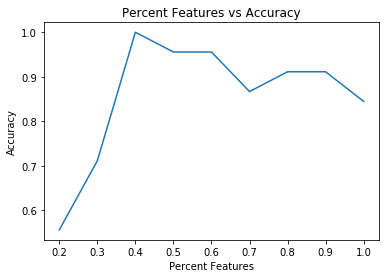

In [9]:
plt.plot(percent_features, acc)
plt.xlabel("Percent Features")
plt.ylabel("Accuracy")
plt.title("Percent Features vs Accuracy")
plt.show()